In [ ]:
#docstring here - what does the code do?

In [1]:
#import modules (straight from wk2&3 so far) - do i need more?
import pandas as pd
import geopandas as gpd
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs

#enable interactive plotting
plt.ion()

In [2]:
#Define functions
#generate handles to create legend for map features
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles

In [3]:
# create a scale bar of length 20 km in the upper right corner of the map
# adapted this question: https://stackoverflow.com/q/32333870
# answered by SO user Siyh: https://stackoverflow.com/a/35705477
def scale_bar(ax, location=(0.92, 0.95)):
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]

    tmc = ccrs.TransverseMercator(sbllx, sblly)
    x0, x1, y0, y1 = ax.get_extent(tmc)
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    plt.plot([sbx, sbx - 20000], [sby, sby], color='k', linewidth=9, transform=tmc)
    plt.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=6, transform=tmc)
    plt.plot([sbx-10000, sbx - 20000], [sby, sby], color='w', linewidth=6, transform=tmc)

    plt.text(sbx, sby-4500, '20 km', transform=tmc, fontsize=8)
    plt.text(sbx-12500, sby-4500, '10 km', transform=tmc, fontsize=8)
    plt.text(sbx-24500, sby-4500, '0 km', transform=tmc, fontsize=8)


In [4]:
#load lga vector outline polygon for central highlands, check row header and CRS
lga = gpd.read_file('data/tas_lga.shp')
print(lga.head())

        LG_PLY_PID          LGA_PID             LGA_NAME     ABB_NAME STATE  \
0  lgp2e684100bbc7  lga5f9b3011df30  Break O'Day Council  Break O'Day   TAS   
1  lgp402890785b9d  lga5f9b3011df30  Break O'Day Council  Break O'Day   TAS   
2  lgp53e14f7c09e8  lga5f9b3011df30  Break O'Day Council  Break O'Day   TAS   
3  lgp566d3f8ff708  lga5f9b3011df30  Break O'Day Council  Break O'Day   TAS   
4  lgp58551735ceaa  lga5f9b3011df30  Break O'Day Council  Break O'Day   TAS   

                                            geometry  
0  POLYGON ((148.34616 -40.98751, 148.34618 -40.9...  
1  POLYGON ((148.32977 -40.92128, 148.32975 -40.9...  
2  POLYGON ((148.34611 -40.98577, 148.34612 -40.9...  
3  POLYGON ((148.32837 -41.24787, 148.32839 -41.2...  
4  POLYGON ((148.32170 -40.92134, 148.32172 -40.9...  


In [5]:
#load land vector polygons for tasmania, check row header and CRS
land = gpd.read_file('data/land_100k.shp')
print(land.head())

     LS_REGION     RAINFALL  \
0  King Island   750-1000mm   
1  King Island   750-1000mm   
2  King Island  1000-1250mm   
3  King Island   750-1000mm   
4  King Island   750-1000mm   

                                             GEO_AGE  \
0                                 Siliurian-Devonian   
1                                 Siliurian-Devonian   
2  Lower Devonian-Tremadocian-Cambrian (Mathinna ...   
3                                 Siliurian-Devonian   
4                                 Siliurian-Devonian   

                                                ROCK   ALTITUDE  \
0           Sedimentary argillaceous (e.g. mudstone)  0 to 300m   
1           Sedimentary argillaceous (e.g. mudstone)  0 to 300m   
2  Sedimentary calcareous (e.g. limestone, dolomite)  0 to 300m   
3           Sedimentary argillaceous (e.g. mudstone)  0 to 300m   
4           Sedimentary argillaceous (e.g. mudstone)  0 to 300m   

                    LANDFORM  \
0  Coastal dunes and beaches   
1  Coasta

In [6]:
#load water vector polygons for tasmania, check row header and CRS
water = gpd.read_file('data/water.shp')
print(water.head())

   WB_ID           WB_NAME       WB_AREA    WB_ELEV  SUBCAT_ID     WB_MAP  \
0   37.0  Pearshape Lagoon  76739.706135  67.955810    10007.0  PEARSHAPE   
1   38.0              None  15753.090750   1.170759    47044.0    SELLARS   
2   39.0              None  77035.664648   1.199716    47044.0    SELLARS   
3   40.0              None  10551.538700   0.192473    47046.0      LOGAN   
4   41.0              None  11750.059306   2.025227    47046.0      LOGAN   

                       WB_INFO    SHAPE_AREA    SHAPE_LEN  \
0  https://wrt.tas.gov.au/cfev  76739.706135  1149.462374   
1  https://wrt.tas.gov.au/cfev  15753.090750   524.353991   
2  https://wrt.tas.gov.au/cfev  77035.664648  1167.638141   
3  https://wrt.tas.gov.au/cfev  10551.538700   554.163424   
4  https://wrt.tas.gov.au/cfev  11750.059306   589.776428   

                                            geometry  
0  POLYGON ((237371.256 5561317.364, 237390.755 5...  
1  POLYGON ((606643.582 5561066.260, 606657.882 5...  
2  PO

In [7]:
#load roads vector lines for tasmania, check row header and CRS
roads = gpd.read_file('data/tas_roads.shp')
print(roads.head())

  REGION ROAD_NO       ROAD_NAME  START_CHNG  END_CHNG  LANE_KM  \
0     NE   A0087     Midland Hwy        0.00      0.80     0.80   
1     NE   A0087     Midland HWY        3.38      3.72     0.33   
2     NE   A1468    Illawarra MR        2.72      2.89     0.17   
3      S   A0498   South Arm HWY        0.00      0.02     0.02   
4     NE   A1565  Lady Barron MR        0.00      9.46    18.92   

               ROAD_CAT                                           geometry  
0            Trunk Road  LINESTRING (512389.184 5397211.740, 512425.095...  
1            Trunk Road  LINESTRING (514982.907 5396553.993, 514978.202...  
2            Trunk Road  LINESTRING (509665.705 5396414.450, 509683.641...  
3  Regional Access Road  LINESTRING (533241.099 5252633.985, 533250.220...  
4            Other Road  LINESTRING (599521.087 5552896.323, 599527.951...  


In [8]:
#load boreholes vector points for tasmania, check row header and CRS
bhs = gpd.read_file('data/drill_eng_geo.shp')
print(bhs.head())

   DRILL_ID     NAME                       KEYWORDS              PURPOSE  \
0     614.0  Bore 1M  Tarraleah - Butlers Gorge Dam  Engineering geology   
1     616.0  Bore 4L  Tarraleah - Butlers Gorge Dam  Engineering geology   
2     617.0  Bore 5L  Tarraleah - Butlers Gorge Dam  Engineering geology   
3     618.0  Bore 3M  Tarraleah - Butlers Gorge Dam  Engineering geology   
4     620.0  Bore 7L  Tarraleah - Butlers Gorge Dam  Engineering geology   

                     COMPANY DRILL_TYPE DATE_DRILL  LENGTH  AZIMUTH  DIP  \
0  Hydro Electric Commission    Diamond    01/1938    26.0      0.0  0.0   
1  Hydro Electric Commission    Diamond    01/1938    22.0      0.0  0.0   
2  Hydro Electric Commission    Diamond    01/1938    17.0      0.0  0.0   
3  Hydro Electric Commission    Diamond    01/1938     6.0      0.0  0.0   
4  Hydro Electric Commission    Diamond    01/1938    39.0      0.0  0.0   

      RL                     geometry  
0  730.0  POINT (146.26172 -42.26638)  
1  730

In [9]:
#check crs of each layer
print(lga.crs)
print(land.crs)
print(water.crs)
print(roads.crs)
print(bhs.crs)

epsg:7844
epsg:28355
epsg:28355
epsg:28355
epsg:4283


In [10]:
#change projection to web mercator (so same as basemap that will be added later, note epsg20251 is correct for Aus)
lga = lga.to_crs(epsg=3857)
land = land.to_crs(epsg=3857)
water = water.to_crs(epsg=3857)
roads = roads.to_crs(epsg=3857)
bhs = bhs.to_crs(epsg=3857)

In [11]:
#check all crs match, use assert to raise an error if not true
lga.crs == land.crs == water.crs == roads.crs == bhs.crs

True

In [12]:
#create a subset of tas lgas to get central highlands lga
#see https://geopandas.org/en/stable/gallery/plot_clip.html
ch_lga = lga[lga["LGA_NAME"] == "Central Highlands Council"]

<AxesSubplot:>

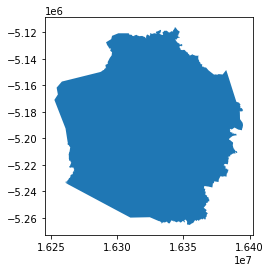

In [13]:
#plot extent of lga
ch_lga.plot()

In [20]:
#clip all state wide vector layers to central highlands lga subset
#https://geopandas.org/en/stable/docs/reference/api/geopandas.clip.html
land_clip = gpd.clip(land, ch_lga)
water_clip = gpd.clip(water, ch_lga)
roads_clip = gpd.clip(roads, ch_lga)
bhs_clip = gpd.clip(bhs, ch_lga)

<AxesSubplot:>

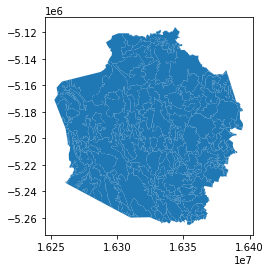

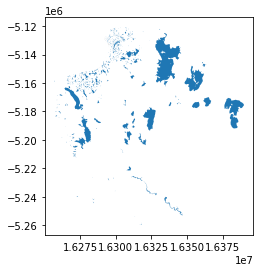

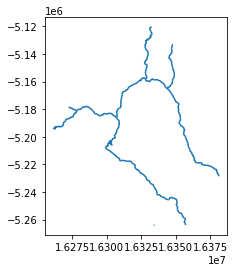

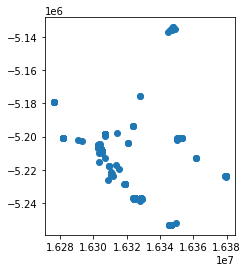

In [21]:
land_clip.plot()
water_clip.plot()
roads_clip.plot()
bhs_clip.plot()

In [30]:
#spatial join between clipped land and water layers and show table
join_lw = gpd.sjoin(land_clip, water_clip, how='inner', lsuffix='left', rsuffix='right')
print(join_lw.head())

            LS_REGION     RAINFALL            GEO_AGE  \
1113  Central Plateau  1500-2000mm  Triassic-Jurassic   
1113  Central Plateau  1500-2000mm  Triassic-Jurassic   
1113  Central Plateau  1500-2000mm  Triassic-Jurassic   
1113  Central Plateau  1500-2000mm  Triassic-Jurassic   
1113  Central Plateau  1500-2000mm  Triassic-Jurassic   

                                      ROCK      ALTITUDE           LANDFORM  \
1113  Metamorphic (e.g. quartzite, schist)  900 to 1200m  Undulating Plains   
1113  Metamorphic (e.g. quartzite, schist)  900 to 1200m  Undulating Plains   
1113  Metamorphic (e.g. quartzite, schist)  900 to 1200m  Undulating Plains   
1113  Metamorphic (e.g. quartzite, schist)  900 to 1200m  Undulating Plains   
1113  Metamorphic (e.g. quartzite, schist)  900 to 1200m  Undulating Plains   

                                               URL_LINK  \
1113  https://nrmdatalibrary.dpipwe.tas.gov.au/FactS...   
1113  https://nrmdatalibrary.dpipwe.tas.gov.au/FactS...   
1113 

In [31]:
#drop the index_right column in order to do second join (python wont allow multiple columns by same name)
join_lw.drop('index_right', axis=1, inplace=True)

In [32]:
#spatial join join_landwater to bh vector layer
join_lwbhs = gpd.sjoin(join_lw, bhs_clip, how='inner')


            LS_REGION RAINFALL GEO_AGE  ROCK ALTITUDE LANDFORM URL_LINK  \
1798  Central Plateau     None    None  None     None     None     None   
1798  Central Plateau     None    None  None     None     None     None   
1798  Central Plateau     None    None  None     None     None     None   
1798  Central Plateau     None    None  None     None     None     None   
1798  Central Plateau     None    None  None     None     None     None   

                                               geometry   WB_ID  \
1798  POLYGON ((16264597.850 -5164812.010, 16264557....  1013.0   
1798  POLYGON ((16264597.850 -5164812.010, 16264557....  1092.0   
1798  POLYGON ((16264597.850 -5164812.010, 16264557....  1013.0   
1798  POLYGON ((16264597.850 -5164812.010, 16264557....  1092.0   
1798  POLYGON ((16264597.850 -5164812.010, 16264557....  1013.0   

              WB_NAME  ...     NAME           KEYWORDS              PURPOSE  \
1798    Lake St Clair  ...  Bore 3L  Lake St Clair Dam  Engineering

In [77]:
print(join_lwbhs.head())

            LS_REGION RAINFALL GEO_AGE  ROCK ALTITUDE LANDFORM  \
1798  Central Plateau     None    None  None     None     None   
1798  Central Plateau     None    None  None     None     None   
1798  Central Plateau     None    None  None     None     None   
1798  Central Plateau     None    None  None     None     None   
1798  Central Plateau     None    None  None     None     None   

                                               geometry          WB_NAME  \
1798  POLYGON ((16264597.850 -5164812.010, 16264557....    Lake St Clair   
1798  POLYGON ((16264597.850 -5164812.010, 16264557....  St Clair Lagoon   
1798  POLYGON ((16264597.850 -5164812.010, 16264557....    Lake St Clair   
1798  POLYGON ((16264597.850 -5164812.010, 16264557....  St Clair Lagoon   
1798  POLYGON ((16264597.850 -5164812.010, 16264557....    Lake St Clair   

           WB_AREA     WB_ELEV  ...     SHAPE_LEN  index_right  DRILL_ID  \
1798  2.903908e+07  730.357842  ...  42658.330630         1775     684

In [ ]:
#drop unused columns to tidy table and better view data
join_lwbhs.drop(['Index_right', 'URL_LINK', 'WB_ID', 'SUBCAT_ID', 'WB_MAP', 'WB_INFO', 'PURPOSE', 'COMPANY', 'DRILL_TYPE'], axis=1, inplace=True)
print(join_lwbhs.head())

In [100]:
#insert a column with area_km2
#https://pandas.pydata.org/docs/getting_started/intro_tutorials/05_add_columns.html
join_lwbhs["AREA_KM2"] = join_lwbhs["SHAPE_AREA"] / 1000000

In [79]:
#run some queries
#print unique values in each column
print(join_lwbhs.nunique())

LS_REGION        2
RAINFALL         6
GEO_AGE          6
ROCK             6
ALTITUDE         4
LANDFORM         3
geometry        19
WB_NAME         20
WB_AREA         22
WB_ELEV         22
SHAPE_AREA      22
SHAPE_LEN       22
index_right    226
DRILL_ID       226
NAME           222
KEYWORDS        36
DATE_DRILL     115
LENGTH         155
AZIMUTH         21
DIP             15
RL             102
AREA_KM2        22
dtype: int64


In [95]:
#Check landform category areas firstly group the data by class 
#https://autogis-site.readthedocs.io/en/latest/notebooks/L2/01-geopandas-basics.html
grouped_landform = join_lwbhs.groupby('LANDFORM')

# then iterate over the group
for key, group in grouped_landform:

    # Let's check how many rows each group has:
    print('Landform:', key)
    print('Number of rows:', len(group), "\n")

Landform: Hills (100-300m)
Number of rows: 318 

Landform: Low Hills (<100m)
Number of rows: 11 

Landform: Undulating Plains
Number of rows: 47 



In [91]:
landform_area = grouped_landform.AREA_KM2.sum().round()
print(landform_area)

LANDFORM
Hills (100-300m)     2253.0
Low Hills (<100m)      38.0
Undulating Plains    1959.0
Name: AREA_KM2, dtype: float64


In [96]:
#Check rock category areas, firstly group the data by class 
#https://autogis-site.readthedocs.io/en/latest/notebooks/L2/01-geopandas-basics.html
grouped_rock = join_lwbhs.groupby('ROCK')

# then iterate over the group
for key, group in grouped_rock:

    # Let's check how many rows each group has:
    print('Rock:', key)
    print('Number of rows:', len(group), "\n")

Rock: Acid igneous (e.g. granite)
Number of rows: 1 

Rock: Basic igneous (e.g. dolerite, basalt)
Number of rows: 50 

Rock: Metamorphic (e.g. quartzite, schist)
Number of rows: 117 

Rock: Sedimentary arenaceous (e.g. sandstone)
Number of rows: 92 

Rock: Sedimentary argillaceous (e.g. mudstone)
Number of rows: 57 

Rock: Sedimentary calcareous (e.g. limestone, dolomite)
Number of rows: 59 



In [98]:
rock_area = grouped_rock.AREA_KM2.sum().round()
print(rock_area)

ROCK
Acid igneous (e.g. granite)                             6.0
Basic igneous (e.g. dolerite, basalt)                 155.0
Metamorphic (e.g. quartzite, schist)                 1717.0
Sedimentary arenaceous (e.g. sandstone)               126.0
Sedimentary argillaceous (e.g. mudstone)             1991.0
Sedimentary calcareous (e.g. limestone, dolomite)     255.0
Name: AREA_KM2, dtype: float64


In [84]:
#name of each rock, geo age and count of bhs in each rock category in central highlands
print(join_lwbhs.groupby(['ROCK', 'GEO_AGE', 'NAME'])['LENGTH'].count())

ROCK                                               GEO_AGE                                             NAME    
Acid igneous (e.g. granite)                        Precambrian                                         HEC-284     1
Basic igneous (e.g. dolerite, basalt)              Cambrian                                            HEC-261     2
                                                                                                       HEC-262     2
                                                                                                       HEC-263     2
                                                                                                       HEC-264     2
                                                                                                                  ..
Sedimentary calcareous (e.g. limestone, dolomite)  Lower Devonian-Tremadocian-Cambrian (Mathinna bed*  HEC-8512    2
                                                                     

In [99]:
#name of each rock, geo age and sum of bhs depth in each rock category in central highlands
print(join_lwbhs.groupby(['ROCK', 'GEO_AGE', 'NAME'])['LENGTH'].sum())

ROCK                                               GEO_AGE                                             NAME    
Acid igneous (e.g. granite)                        Precambrian                                         HEC-284      18.90
Basic igneous (e.g. dolerite, basalt)              Cambrian                                            HEC-261      73.86
                                                                                                       HEC-262     123.14
                                                                                                       HEC-263     122.74
                                                                                                       HEC-264      73.60
                                                                                                                    ...  
Sedimentary calcareous (e.g. limestone, dolomite)  Lower Devonian-Tremadocian-Cambrian (Mathinna bed*  HEC-8512     91.44
                                  